In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!git clone https://github.com/eriklindernoren/PyTorch-GAN

Cloning into 'PyTorch-GAN'...
remote: Enumerating objects: 1283, done.
remote: Total 1283 (delta 0), reused 0 (delta 0), pack-reused 1283 (from 1)
Receiving objects: 100% (1283/1283), 68.04 MiB | 17.91 MiB/s, done.
Resolving deltas: 100% (751/751), done.


In [2]:
%cd PyTorch-GAN

/content/PyTorch-GAN


In [3]:
!ls

assets	data  implementations  LICENSE	README.md  requirements.txt


In [4]:
pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:
%cd implementations/acgan/

/content/PyTorch-GAN/implementations/acgan


In [6]:
def poison_dataset(dataset, poison_ratio=0.2):
    """
    Function to poison the dataset by changing a percentage of random samples
    to have a random label.

    Args:
        dataset: The dataset to be poisoned (assumed to be torchvision dataset).
        poison_ratio: The ratio of samples that should have a randomly changed label.

    Returns:
        poisoned_dataset: The poisoned version of the dataset.
    """
    num_samples = len(dataset)
    num_poisoned_samples = int(num_samples * poison_ratio)
    poisoned_indices = np.random.choice(num_samples, num_poisoned_samples, replace=False)

    poisoned_dataset = []
    for i in range(num_samples):
        img, label = dataset[i]
        if i in poisoned_indices:
            label = np.random.choice([l for l in range(10) if l != label])  # Avoid keeping the same label
        poisoned_dataset.append((img, label))

    return poisoned_dataset


In [7]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=16, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=200, help="interval between image sampling")

opt = parser.parse_args([]) # remove arguments from this list if you do intend to pass arguments

# Load the original MNIST dataset
original_dataset = datasets.MNIST(
    "../../data/mnist",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]


Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.91MB/s]

Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



In [8]:

# Poison the dataset by changing a percentage of dataset
poisoned_dataset = poison_dataset(original_dataset, poison_ratio=0.2)

# Use the poisoned dataset for the DataLoader
dataloader = torch.utils.data.DataLoader(
    poisoned_dataset,
    batch_size=opt.batch_size,
    shuffle=True,
)


In [9]:
print(opt)
cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.latent_dim)

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)

    # Create the 'images' directory if it doesn't exist
    os.makedirs("images", exist_ok=True)

    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)


# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
        )
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)


Namespace(n_epochs=50, batch_size=256, lr=0.0002, b1=0.5, b2=0.999, n_cpu=16, latent_dim=100, n_classes=10, img_size=32, channels=1, sample_interval=200)


<ipython-input-9-342b9ce9a61c>:130: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Streaming output truncated to the last 5000 lines.
[Epoch 28/50] [Batch 170/235] [D loss: 1.134589, acc: 86%] [G loss: 1.095951]
[Epoch 28/50] [Batch 171/235] [D loss: 1.136847, acc: 89%] [G loss: 1.122563]
[Epoch 28/50] [Batch 172/235] [D loss: 1.131875, acc: 89%] [G loss: 1.096188]
[Epoch 28/50] [Batch 173/235] [D loss: 1.126816, acc: 88%] [G loss: 1.068413]
[Epoch 28/50] [Batch 174/235] [D loss: 1.138243, acc: 87%] [G loss: 1.075854]
[Epoch 28/50] [Batch 175/235] [D loss: 1.133388, acc: 88%] [G loss: 1.076105]
[Epoch 28/50] [Batch 176/235] [D loss: 1.149588, acc: 86%] [G loss: 1.077732]
[Epoch 28/50] [Batch 177/235] [D loss: 1.142224, acc: 88%] [G loss: 1.090399]
[Epoch 28/50] [Batch 178/235] [D loss: 1.123370, acc: 87%] [G loss: 1.092254]
[Epoch 28/50] [Batch 179/235] [D loss: 1.138679, acc: 88%] [G loss: 1.074832]
[Epoch 28/50] [Batch 180/235] [D loss: 1.124246, acc: 89%] [G loss: 1.100759]
[Epoch 28/50] [Batch 181/235] [D loss: 1.127298, acc: 87%] [G loss: 1.069477]
[Epoch 28/50]

In [10]:

test_dataset = datasets.MNIST(
    "../../data/mnist",
    train=False,  # Set train=False to load the test dataset
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)

# Create the test DataLoader
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=opt.batch_size,
    shuffle=True,  # No need to shuffle the test dataset
)

generator.eval()  # Set to evaluation mode
discriminator.eval()

all_preds = []
all_labels = []
all_validities = []

with torch.no_grad():  # Disable gradient computation for faster performance
    for imgs, labels in test_dataloader:
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # Generate predictions from discriminator
        validity, pred_labels = discriminator(real_imgs)

        # Save predictions and actual labels for evaluation
        all_preds.append(pred_labels.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_validities.append(validity.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_validities = np.concatenate(all_validities, axis=0)


# Calculate accuracy
pred_classes = np.argmax(all_preds, axis=1)
accuracy = np.mean(pred_classes == all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 97.67%


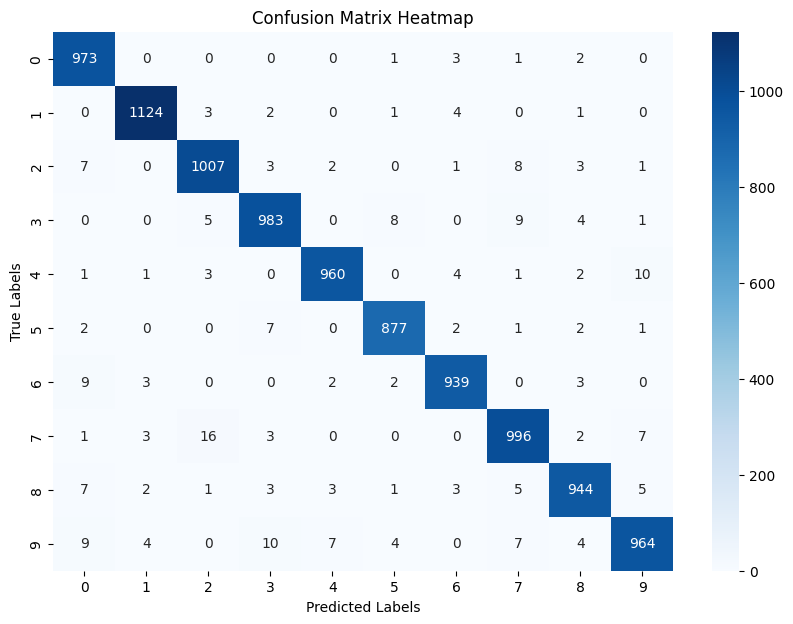

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_mat = confusion_matrix(all_labels, pred_classes)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


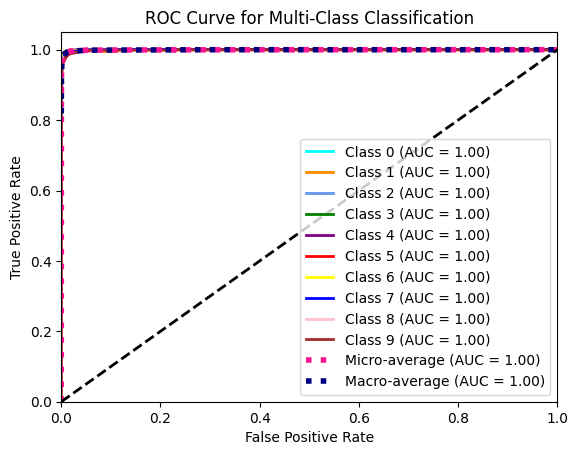

Micro-average AUC: 0.9994
Macro-average AUC: 0.9995


In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC curve calculation
n_classes = opt.n_classes
labels_binarized = label_binarize(all_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(labels_binarized.ravel(), all_preds.ravel())
micro_auc = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Plot ROC curve for each class
plt.figure()
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "purple", "red", "yellow", "blue", "pink", "brown"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro and macro average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4, label=f'Micro-average (AUC = {micro_auc:.2f})')
plt.plot(all_fpr, mean_tpr, color='navy', linestyle=':', linewidth=4, label=f'Macro-average (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()

print(f"Micro-average AUC: {micro_auc:.4f}")
print(f"Macro-average AUC: {macro_auc:.4f}")


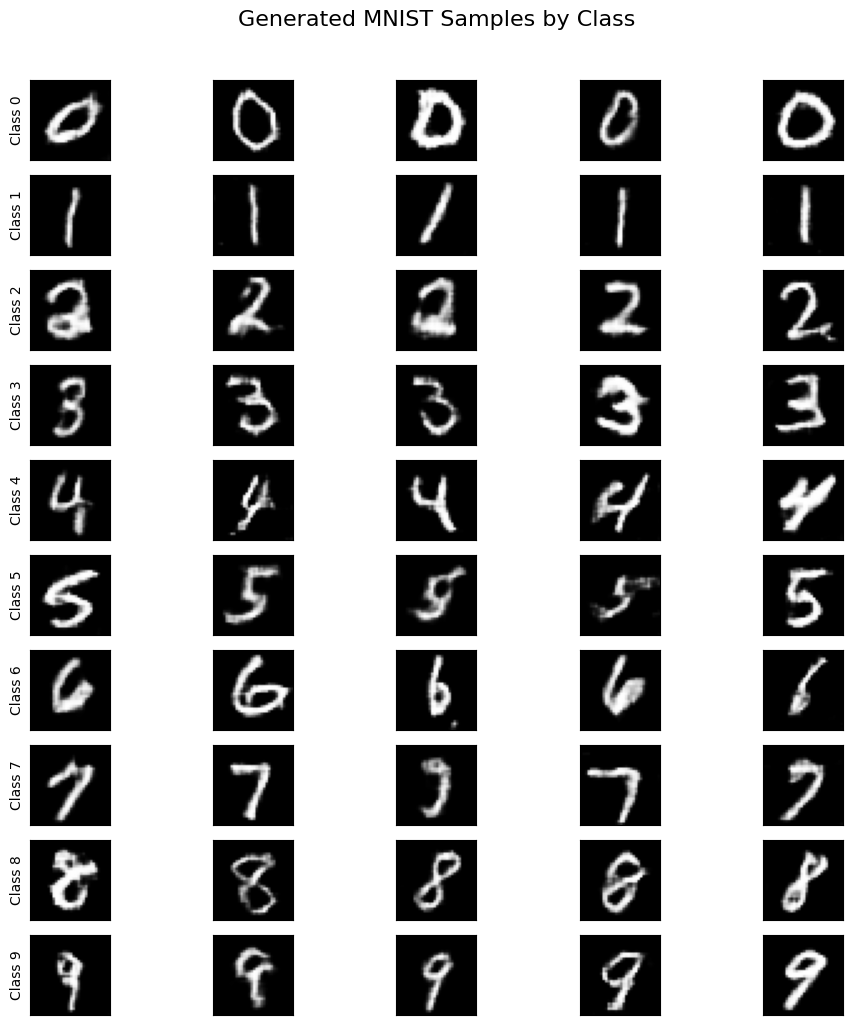

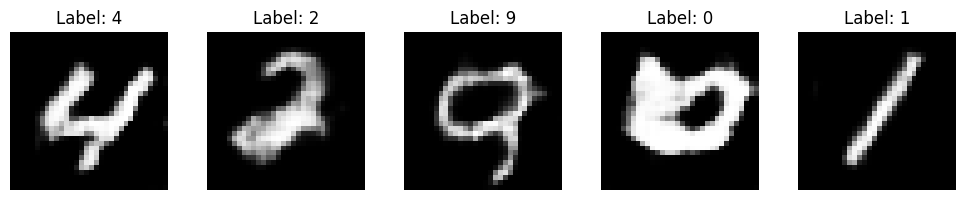

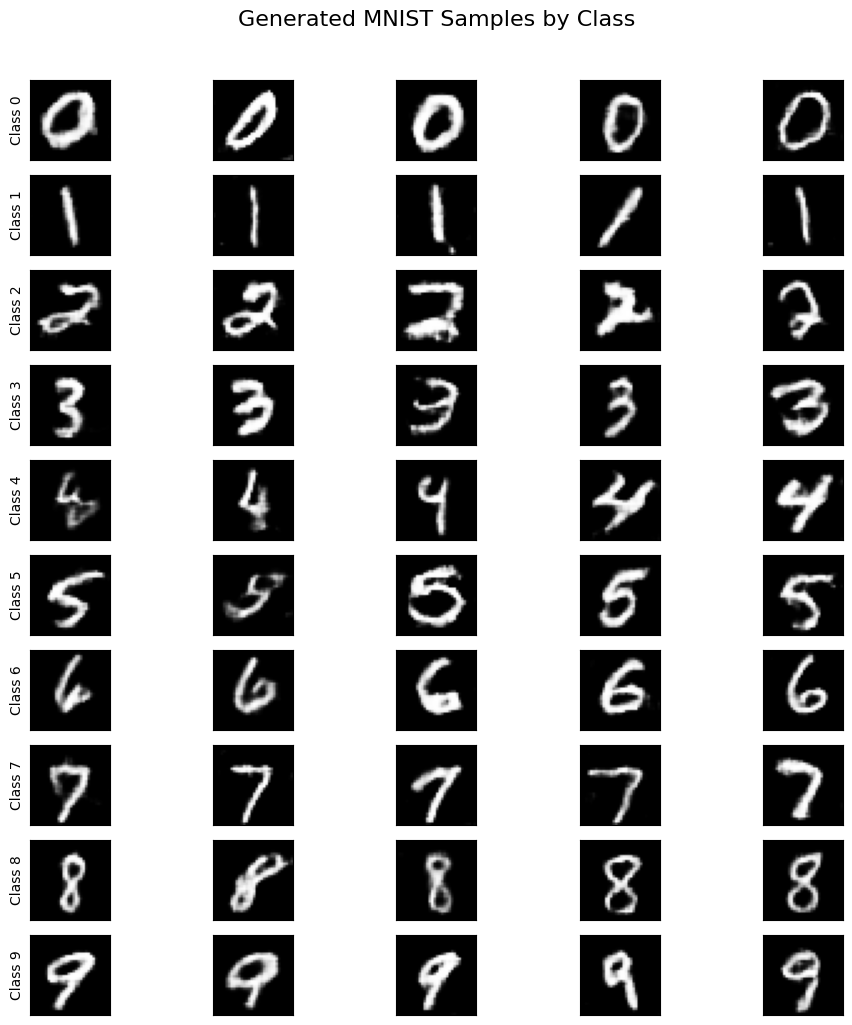

Predicted Labels by Discriminator:
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 9 3 9 4 9 4 4 8 9 5 8 8 6 6 6 6 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def generate_and_display_samples(generator, num_samples=5, latent_dim=100, num_classes=10):
    """
    Generate and display samples from the conditional MNIST generator.

    Parameters:
    - generator: Trained generator model
    - num_samples: Number of samples to generate per class
    - latent_dim: Dimension of the latent noise vector
    - num_classes: Number of classes (10 for MNIST)
    """
    fig = plt.figure(figsize=(10, 10))
    total_samples = num_samples * num_classes

    generator.eval()
    device = next(generator.parameters()).device

    with torch.no_grad():
        z = torch.randn(total_samples, latent_dim, device=device)
        labels = torch.tensor(
            [i for i in range(num_classes) for _ in range(num_samples)],
            device=device
        )
        generated_images = generator(z, labels)
        generated_images = (generated_images.cpu().numpy() * 0.5 + 0.5).squeeze(1)  # Remove channel dimension

    for idx, img in enumerate(generated_images):
        ax = fig.add_subplot(num_classes, num_samples, idx + 1)
        plt.imshow(img, cmap='gray')  # Grayscale for MNIST
        ax.set_xticks([])
        ax.set_yticks([])

        if idx % num_samples == 0:
            ax.set_ylabel(f'Class {idx // num_samples}', fontsize=10)

    plt.suptitle('Generated MNIST Samples by Class', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    return generated_images, labels

def generate_specific_samples(generator, specific_labels, latent_dim=100):
    """
    Generate samples for specific labels in MNIST.
    """
    generator.eval()
    device = next(generator.parameters()).device
    num_samples = len(specific_labels)

    plt.figure(figsize=(num_samples * 2, 2))

    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        labels = torch.tensor(specific_labels, device=device)
        generated_images = generator(z, labels)
        generated_images = (generated_images.cpu().numpy() * 0.5 + 0.5).squeeze(1)

    for idx, (img, label) in enumerate(zip(generated_images, specific_labels)):
        plt.subplot(1, num_samples, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return generated_images, labels

def test_discriminator_on_generated(discriminator, generator, num_samples=5, latent_dim=100, num_classes=10):
    """
    Generate samples using the generator and classify them using the discriminator.
    """
    generated_images, labels = generate_and_display_samples(generator, num_samples, latent_dim, num_classes)
    generated_images = torch.tensor(generated_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

    device = next(discriminator.parameters()).device
    generated_images = generated_images.to(device)

    discriminator.eval()
    with torch.no_grad():
        _, predicted_labels = discriminator(generated_images)
        predicted_classes = torch.argmax(predicted_labels, dim=1).cpu().numpy()

    print("Predicted Labels by Discriminator:")
    print(predicted_classes)

# Example usage:
if __name__ == "__main__":
    generate_and_display_samples(generator, num_samples=5)
    specific_labels = [4, 2, 9, 0, 1]
    generate_specific_samples(generator, specific_labels)
    test_discriminator_on_generated(discriminator, generator, num_samples=5)


In [ ]:
#Original code
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
#
os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=2, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=16, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=200, help="interval between image sampling")
# The following line has been changed to not parse arguments from the command line
opt = parser.parse_args([]) # remove arguments from this list if you do intend to pass arguments
print(opt)
#
cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.latent_dim)

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)


# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
        )
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)
